# Import

In [1]:
!pip install torchsummaryX

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchsummaryX import summary
from tqdm import tqdm
import pandas as pd
from scipy import stats
import joypy
import matplotlib.pyplot as plt

import pickle
import os

from sklearn.model_selection import train_test_split


In [6]:
class Dist(stats.rv_continuous):
  def _cdf(self_dist, x):  # Rename self to self_dist so that self refers to outer class
      conditions = [0<=x<0.3, 0.3<=x<0.6, 0.6<=x<=1]
      choices = [1/3, 1/3, 1/3]
      return np.select(conditions, choices, default=0)

dist = Dist(a=0, b=1, name="deterministic")
# Model takes in sequence data until time j and ouputs prediction value for time j+1.
# Therefore we need the number of queries in thej+1's interval
# num_templates = int(num_template_df[j+1]/10) # Divide by 10 so it runs faster
# num_params = 30 # Generate 30 parameter values for this specific parameter
generated_param_ith = []
dist.rvs(size=20)


array([5.40063687e-15, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       7.43230688e-15, 0.00000000e+00, 8.10072229e-15, 0.00000000e+00,
       1.00000000e+00, 7.04049321e-15, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

# Constants

In [2]:
num_quantiles = 11 # H_in
look_back_window = 5 # L
hidden_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load Data

In [3]:
with open('../data/query_to_df_original_map.pickle', 'rb') as f:
  query_to_df_original_map = pickle.load(f)

with open('../data/query_to_df_normalized_map.pickle', 'rb') as f:
  query_to_df_normalized_map = pickle.load(f)

with open('../data/query_to_dtype_map.pickle', 'rb') as f:
  query_to_dtype_map = pickle.load(f)

with open('../data/query_to_stats.pickle', 'rb') as f:
  query_to_stats = pickle.load(f)

with open('../data/query_to_param_X.pickle', 'rb') as f:
  query_to_param_X = pickle.load(f)

with open('../data/query_to_param_Y.pickle', 'rb') as f:
  query_to_param_Y = pickle.load(f)


In [4]:
class ParamQuantileData():
  """ 
  Contains train and test data for certain parameter
  """

  def __init__(self, X_train, X_test, Y_train, Y_test):
    self.X_train = X_train
    self.X_test = X_test
    self.Y_train = Y_train
    self.Y_test = Y_test
  
  def get_train_test_data(self):
    return self.X_train, self.X_test, self.Y_train, self.Y_test


class QueryQuantileData():
  """
  Contains train/test data for all parameters
  """
  def __init__(self, query_template, all_param_quantile_data):
    self.query_template = query_template
    self.param_quantile_data = all_param_quantile_data

In [5]:
all_query_qunatile_data = {}
for qt in tqdm(query_to_param_X.keys()):
  param_X = query_to_param_X[qt]
  param_Y = query_to_param_Y[qt]

  all_param_quantile_data = []
  for i in range(len(param_X)):
    if query_to_dtype_map[qt][i] == "string":
      all_param_quantile_data.append(None)
      continue

    param_col_X = param_X[i]
    param_col_Y = param_Y[i]

    # Split into train test set
    X_train, X_test, Y_train, Y_test = train_test_split(param_col_X, param_col_Y, shuffle=False, test_size=0.1)
    # print(X_train.dtype)

    # X: (N, L, H_in) to (L, N, H_in);
    X_train, X_test = np.transpose(X_train, (1, 0, 2)), np.transpose(X_test, (1, 0, 2))
    # print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
    all_param_quantile_data.append(ParamQuantileData(X_train, X_test, Y_train, Y_test))

  all_query_qunatile_data[qt] = QueryQuantileData(qt, all_param_quantile_data)

100%|██████████| 31/31 [00:00<00:00, 1647.89it/s]


In [6]:
all_query_qunatile_data["DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3"].param_quantile_data[0].X_train.shape

(5, 27, 11)

# Model

In [7]:
from torch.nn.modules import dropout
class Network(nn.Module):

    def __init__(self, input_size, output_size, hidden_size=128, num_layers=2): # You can add any extra arguments as you wish

        super(Network, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, dropout=0.1)
        self.classification = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=output_size)
        )

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        # output: (L, 1 * H_out)

        out = self.classification(output)
        return out

# model = Network(num_quantiles, num_quantiles, hidden_size).to(device)
# summary(model, torch.tensor(X_train[:, :1, :]).to(device).float())

# Model Parameters

In [8]:
epochs = 50
lr = 0.0001
# loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(X_train.shape[1] * epochs))

# Model Training

In [53]:
def save_checkpoint(ckpt_path, filename, query_template, model, epoch, optimizer, scheduler):
    path = os.path.join(ckpt_path, f"{filename}")

    if not os.path.exists(ckpt_path):
        os.makedirs(ckpt_path)

    save_dict = {'model_state': model.state_dict(),
                'epoch': epoch,
                 'qt': query_template,
                 }

    if optimizer != None:
      save_dict['optimizer_state'] = optimizer.state_dict()
    if scheduler != None:
      save_dict['scheduler_state'] = scheduler.state_dict()

    torch.save(save_dict, path)
    print(f"=> saved the model {filename} to {path}")

In [54]:
query_template_to_index = {}
for template_index, (qt, query_quantile_data_obj) in enumerate(all_query_qunatile_data.items()):
    print(f"Processing query {template_index}...")

    query_template_to_index[qt] = template_index

    for param_index, param_quantile_data_obj in enumerate(query_quantile_data_obj.param_quantile_data):
        print(f"Training for param {param_index}...")

        # Skip string param
        if param_quantile_data_obj == None:
            # query_template_to_model[qt].append(None)
            continue

        X_train, X_test, Y_train, Y_test = param_quantile_data_obj.get_train_test_data()

        model = Network(num_quantiles, num_quantiles, hidden_size, 2).to(device)
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(X_train.shape[1] * epochs))

        for epoch in range(epochs):
            model.train()
            arr = np.arange(X_train.shape[1])
            np.random.shuffle(arr)
            train_loss = 0
            batch_bar = tqdm(total=X_train.shape[1], dynamic_ncols=True, leave=False, position=0, desc='Train') 
            for ind in arr:
                seq = torch.tensor(X_train[:, ind:ind+1, :]).to(device).float()
                labels = torch.tensor(Y_train[ind]).to(device).float()
                optimizer.zero_grad()
                y_pred = model(seq)
                single_loss = loss_function(y_pred[-1, -1, :], labels)
                single_loss.backward()
                optimizer.step()
                scheduler.step()
                train_loss += float(single_loss)

                batch_bar.set_postfix(
                    loss="{:.04f}".format(float(train_loss / (ind + 1))),
                    lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
                batch_bar.update()

            train_loss /= X_train.shape[1]
            batch_bar.close()
            
            # Validation loss
            model.eval()
            val_loss = 0
            batch_bar = tqdm(total=X_train.shape[1], dynamic_ncols=True, leave=False, position=0, desc='Train') 
            for ind in range(X_test.shape[1]):
                seq = torch.tensor(X_test[:, ind:ind+1, :]).to(device).float()
                labels = torch.tensor(Y_test[ind]).to(device).float()

                with torch.no_grad():
                    y_pred = model(seq)

                single_loss = loss_function(y_pred[-1, -1, :], labels)
                val_loss += float(single_loss)
                batch_bar.update()
            val_loss /= X_test.shape[1]
            batch_bar.close()

        # print(f"[LSTM FIT]epoch: {epoch + 1:3}, train_loss: {train_loss:10.8f}, val_loss: {val_loss:10.8f}")
        filename = f"{template_index}_{param_index}"
        save_checkpoint("./models/v1", filename, qt, model, epoch, optimizer, scheduler)

Processing query 0...
Training for param 0...


=> saved the model 0_0 to ./models/v1/0_0
Training for param 1...


=> saved the model 0_1 to ./models/v1/0_1
Training for param 2...


=> saved the model 0_2 to ./models/v1/0_2
Processing query 1...
Training for param 0...


=> saved the model 1_0 to ./models/v1/1_0
Training for param 1...


=> saved the model 1_1 to ./models/v1/1_1
Training for param 2...


=> saved the model 1_2 to ./models/v1/1_2
Training for param 3...


=> saved the model 1_3 to ./models/v1/1_3
Training for param 4...


=> saved the model 1_4 to ./models/v1/1_4
Training for param 5...


=> saved the model 1_5 to ./models/v1/1_5
Training for param 6...


=> saved the model 1_6 to ./models/v1/1_6
Training for param 7...
Processing query 2...
Training for param 0...


=> saved the model 2_0 to ./models/v1/2_0
Training for param 1...


=> saved the model 2_1 to ./models/v1/2_1
Training for param 2...


=> saved the model 2_2 to ./models/v1/2_2
Processing query 3...
Training for param 0...


=> saved the model 3_0 to ./models/v1/3_0
Training for param 1...


=> saved the model 3_1 to ./models/v1/3_1
Training for param 2...


=> saved the model 3_2 to ./models/v1/3_2
Training for param 3...


=> saved the model 3_3 to ./models/v1/3_3
Training for param 4...


=> saved the model 3_4 to ./models/v1/3_4
Training for param 5...


=> saved the model 3_5 to ./models/v1/3_5
Training for param 6...


=> saved the model 3_6 to ./models/v1/3_6
Processing query 4...
Training for param 0...


=> saved the model 4_0 to ./models/v1/4_0
Training for param 1...


=> saved the model 4_1 to ./models/v1/4_1
Training for param 2...


=> saved the model 4_2 to ./models/v1/4_2
Training for param 3...


=> saved the model 4_3 to ./models/v1/4_3
Training for param 4...


=> saved the model 4_4 to ./models/v1/4_4
Training for param 5...


=> saved the model 4_5 to ./models/v1/4_5
Training for param 6...


=> saved the model 4_6 to ./models/v1/4_6
Training for param 7...


=> saved the model 4_7 to ./models/v1/4_7
Training for param 8...
Processing query 5...
Training for param 0...


=> saved the model 5_0 to ./models/v1/5_0
Training for param 1...


=> saved the model 5_1 to ./models/v1/5_1
Training for param 2...


=> saved the model 5_2 to ./models/v1/5_2
Training for param 3...


=> saved the model 5_3 to ./models/v1/5_3
Training for param 4...


=> saved the model 5_4 to ./models/v1/5_4
Training for param 5...


=> saved the model 5_5 to ./models/v1/5_5
Processing query 6...
Training for param 0...


=> saved the model 6_0 to ./models/v1/6_0
Training for param 1...


=> saved the model 6_1 to ./models/v1/6_1
Training for param 2...


=> saved the model 6_2 to ./models/v1/6_2
Processing query 7...
Training for param 0...


=> saved the model 7_0 to ./models/v1/7_0
Training for param 1...


=> saved the model 7_1 to ./models/v1/7_1
Training for param 2...


=> saved the model 7_2 to ./models/v1/7_2
Processing query 8...
Training for param 0...


=> saved the model 8_0 to ./models/v1/8_0
Training for param 1...


=> saved the model 8_1 to ./models/v1/8_1
Training for param 2...
Processing query 9...
Training for param 0...


=> saved the model 9_0 to ./models/v1/9_0
Training for param 1...


=> saved the model 9_1 to ./models/v1/9_1
Training for param 2...


=> saved the model 9_2 to ./models/v1/9_2
Processing query 10...
Training for param 0...


=> saved the model 10_0 to ./models/v1/10_0
Training for param 1...


=> saved the model 10_1 to ./models/v1/10_1
Processing query 11...
Training for param 0...


=> saved the model 11_0 to ./models/v1/11_0
Training for param 1...


=> saved the model 11_1 to ./models/v1/11_1
Processing query 12...
Training for param 0...


=> saved the model 12_0 to ./models/v1/12_0
Training for param 1...


=> saved the model 12_1 to ./models/v1/12_1
Processing query 13...
Training for param 0...


=> saved the model 13_0 to ./models/v1/13_0
Processing query 14...
Training for param 0...


=> saved the model 14_0 to ./models/v1/14_0
Training for param 1...


=> saved the model 14_1 to ./models/v1/14_1
Training for param 2...


=> saved the model 14_2 to ./models/v1/14_2
Processing query 15...
Training for param 0...


=> saved the model 15_0 to ./models/v1/15_0
Training for param 1...


=> saved the model 15_1 to ./models/v1/15_1
Training for param 2...


=> saved the model 15_2 to ./models/v1/15_2
Processing query 16...
Training for param 0...


=> saved the model 16_0 to ./models/v1/16_0
Training for param 1...


=> saved the model 16_1 to ./models/v1/16_1
Training for param 2...


=> saved the model 16_2 to ./models/v1/16_2
Processing query 17...
Training for param 0...


=> saved the model 17_0 to ./models/v1/17_0
Training for param 1...


=> saved the model 17_1 to ./models/v1/17_1
Training for param 2...


=> saved the model 17_2 to ./models/v1/17_2
Training for param 3...


=> saved the model 17_3 to ./models/v1/17_3
Processing query 18...
Training for param 0...


=> saved the model 18_0 to ./models/v1/18_0
Training for param 1...


=> saved the model 18_1 to ./models/v1/18_1
Training for param 2...


=> saved the model 18_2 to ./models/v1/18_2
Processing query 19...
Training for param 0...


=> saved the model 19_0 to ./models/v1/19_0
Training for param 1...


=> saved the model 19_1 to ./models/v1/19_1
Processing query 20...
Training for param 0...


=> saved the model 20_0 to ./models/v1/20_0
Processing query 21...
Training for param 0...


=> saved the model 21_0 to ./models/v1/21_0
Processing query 22...
Training for param 0...


=> saved the model 22_0 to ./models/v1/22_0
Training for param 1...


=> saved the model 22_1 to ./models/v1/22_1
Training for param 2...


=> saved the model 22_2 to ./models/v1/22_2
Training for param 3...


=> saved the model 22_3 to ./models/v1/22_3
Training for param 4...


=> saved the model 22_4 to ./models/v1/22_4
Training for param 5...


=> saved the model 22_5 to ./models/v1/22_5
Processing query 23...
Training for param 0...


=> saved the model 23_0 to ./models/v1/23_0
Training for param 1...


=> saved the model 23_1 to ./models/v1/23_1
Training for param 2...


=> saved the model 23_2 to ./models/v1/23_2
Training for param 3...
Training for param 4...


=> saved the model 23_4 to ./models/v1/23_4
Training for param 5...


=> saved the model 23_5 to ./models/v1/23_5
Training for param 6...


=> saved the model 23_6 to ./models/v1/23_6
Processing query 24...
Training for param 0...


=> saved the model 24_0 to ./models/v1/24_0
Training for param 1...


=> saved the model 24_1 to ./models/v1/24_1
Training for param 2...


=> saved the model 24_2 to ./models/v1/24_2
Training for param 3...


=> saved the model 24_3 to ./models/v1/24_3
Training for param 4...


=> saved the model 24_4 to ./models/v1/24_4
Processing query 25...
Training for param 0...


=> saved the model 25_0 to ./models/v1/25_0
Training for param 1...


=> saved the model 25_1 to ./models/v1/25_1
Training for param 2...


=> saved the model 25_2 to ./models/v1/25_2
Processing query 26...
Training for param 0...


=> saved the model 26_0 to ./models/v1/26_0
Training for param 1...


=> saved the model 26_1 to ./models/v1/26_1
Training for param 2...


=> saved the model 26_2 to ./models/v1/26_2
Processing query 27...
Training for param 0...


=> saved the model 27_0 to ./models/v1/27_0
Training for param 1...


=> saved the model 27_1 to ./models/v1/27_1
Training for param 2...


=> saved the model 27_2 to ./models/v1/27_2
Training for param 3...


=> saved the model 27_3 to ./models/v1/27_3
Processing query 28...
Training for param 0...


=> saved the model 28_0 to ./models/v1/28_0
Training for param 1...


=> saved the model 28_1 to ./models/v1/28_1
Training for param 2...


=> saved the model 28_2 to ./models/v1/28_2
Training for param 3...


=> saved the model 28_3 to ./models/v1/28_3
Processing query 29...
Training for param 0...


=> saved the model 29_0 to ./models/v1/29_0
Training for param 1...


=> saved the model 29_1 to ./models/v1/29_1
Training for param 2...


=> saved the model 29_2 to ./models/v1/29_2
Training for param 3...


=> saved the model 29_3 to ./models/v1/29_3
Training for param 4...


=> saved the model 29_4 to ./models/v1/29_4
Training for param 5...


=> saved the model 29_5 to ./models/v1/29_5
Processing query 30...
Training for param 0...


=> saved the model 30_0 to ./models/v1/30_0
Training for param 1...


=> saved the model 30_1 to ./models/v1/30_1


# Param Prediction

In [9]:
# Each interval (time step) is vectorized into 4 bins --> [20, 40, 60, 80] percentiles
def left_boundary(x):
  return x.quantile(0.01)
def q1(x):
  return x.quantile(0.1)
def q2(x):
  return x.quantile(0.2)
def q3(x):
  return x.quantile(0.3)
def q4(x):
  return x.quantile(0.4)
def q5(x):
  return x.quantile(0.5)
def q6(x):
  return x.quantile(0.6)
def q7(x):
  return x.quantile(0.7)
def q8(x):
  return x.quantile(0.8)
def q9(x):
  return x.quantile(0.9)
def right_boundary(x):
  return x.quantile(0.99)

# quantiles = [q1, q2, q3, q4, q5, q6, q7, q8, q9]
quantiles = [left_boundary, q1, q2, q3, q4, q5, q6, q7, q8, q9, right_boundary]
quantile_names = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Prediction interval hyperparameters
prediction_interval = pd.Timedelta("2S") # Each interval has two seconds
prediction_seq_len = 5 # 5 data points
prediction_horizon = pd.Timedelta("2S")
# total time = interval * seq_len

In [15]:
t = query_to_df_normalized_map["DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3"].index.max()
t

Timestamp('2022-03-08 11:30:01.021000-0500', tz='pytz.FixedOffset(-300)')

In [40]:
# Get all parameters for a query and compare it with actual data
def get_parameters_for(query_template, timestamp, num_queries):
  target_timestamp = pd.Timestamp(timestamp)

  template_original_df = query_to_df_original_map[query_template]
  template_normalized_df = query_to_df_normalized_map[query_template]
  template_dtypes = query_to_dtype_map[query_template]
  template_stats = query_to_stats[query_template]
  template_index = query_template_to_index[query_template]
  param_X = query_to_param_X[query_template]
  param_Y = query_to_param_Y[query_template]

  generated_params = []

  for i, col in enumerate(template_normalized_df):
    if template_dtypes[i] == "string":
      print("Skipping string columns")
      continue

    param_col_X = param_X[col]

    # Get corresponding model
    model = Network(num_quantiles, num_quantiles, hidden_size, 2)
    filepath = os.path.join("./models/v1", f"{template_index}_{i}")
    state_dict = torch.load(filepath)
    model.load_state_dict(state_dict["model_state"])

    # Compute how many predictions need to be made
    start_timestamp = template_normalized_df.index.max()
    num_predictions = int((target_timestamp-start_timestamp)/prediction_interval)
    
    # Continously make predictions until target_timestamp
    seq = param_col_X[-1]
    seq = seq[None, :, :]
    seq = np.transpose(seq, (1, 0, 2))
    seq = torch.tensor(seq).to(device).float()
    for j in tqdm(range(num_predictions)):
      # Get predicted quantiles from the model
      with torch.no_grad():
        pred = model(seq)

      # Ensure prediction quantile values are strictly increasing
      pred = pred[-1, -1, :]
      pred = torch.cummax(pred, dim=0).values

      # Add pred to original seq to create new seq for next time stamp
      seq = torch.squeeze(seq, axis=1)
      seq = torch.cat((seq[:-1, :], pred[None, :]), axis=0)
      seq = seq[:, None, :]

    pred = pred.cpu().detach().numpy()

    # Un-normalize the quantiles
    mean, std = template_stats[i]
    if std != 0:
      pred = pred * std + mean
    else:
      pred = pred + mean

    class Dist(stats.rv_continuous):
        def _cdf(self, x):
          conditions = [x<=pred[0]]
          for k in range(pred.shape[0]-1):
              conditions.append(pred[k]<=x<=pred[k+1])
          choices = [quantile_name/100 for quantile_name in quantile_names]
          return np.select(conditions, choices, default=0)

    dist = Dist(a=pred[0], b=pred[-1], name="deterministic")
    # Model takes in sequence data until time j and ouputs prediction value for time j+1.
    # Therefore we need the number of queries in thej+1's interval
    # num_templates = int(num_template_df[j+1]/10) # Divide by 10 so it runs faster
    # num_params = 30 # Generate 30 parameter values for this specific parameter
    
    generated_param_ith = []
    try:
      for _ in range(num_queries):
        generated_param_ith.append(dist.rvs()) 
    except:
      # If all predicted quantiles have the same value, then a continous cdf cannot be constructed.
      # Just take any predicted quantile value as the prediction.
      for _ in range(num_queries):
        generated_param_ith.append(pred[0])

    generated_params.append(generated_param_ith)
  return generated_params
    
  

      



In [41]:
get_parameters_for("DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3", "2022-03-08 11:30:06.021000-0500", 10)

100%|██████████| 2/2 [00:00<00:00, 1267.54it/s]


[[4114.588867187502,
  4095.0644531250027,
  4090.128662109378,
  4114.588867187502,
  4095.064453125,
  4095.0644531250027,
  4090.128662109375,
  4095.064453125003,
  4090.128662109375,
  4114.588867187503],
 [6.388166427612314,
  9.110973358154293,
  0.9649767875671448,
  2.7887346744537354,
  1.8497371673583967,
  2.788734674453745,
  5.488673686981199,
  1.8497371673584055,
  5.488673686981199,
  1.8497371673584018],
 [1.0008933544158936,
  1.00003981590271,
  1.0008933544158936,
  1.0008933544158936,
  1.00003981590271,
  1.0008933544158936,
  1.0008933544158936,
  1.0000398159027166,
  1.0008933544158845,
  1.0008933544158936]]

In [ ]:
# Get all parameters for a query and compare it with actual data
def get_all_parameters_for(query_template:str):
  template_original_df = query_to_df_original_map[query_template]
  template_normalized_df = query_to_df_normalized_map[query_template]
  template_dtypes = query_to_dtype_map[query_template]
  template_stats = query_to_stats[query_template]
  # model = Network(num_quantiles, num_quantiles, hidden_size, 2)
  template_index = query_template_to_index[query_template]

  # display(template_normalized_df)

  for i, col in enumerate(template_normalized_df):
    # print(f"Processing parameter {i+1}...")
    # Skip non-numerical columns
    if template_dtypes[i] == "string":
      continue

    # Get corresponding model
    model = Network(num_quantiles, num_quantiles, hidden_size, 2)
    filepath = os.path.join("./models/v1", f"{template_index}_{i}")
    state_dict = torch.load(filepath)
    model.load_state_dict(state_dict["model_state"])

    # Group by pred_iterval and get quantile data
    time_series_df = template_normalized_df[col].resample(prediction_interval).agg(quantiles)
    time_series_df = time_series_df.astype(float)

    # Get number of queries in each time interval
    num_template_df = template_normalized_df[col].resample(prediction_interval).count()
    # display(num_template_df.head())
    # display(time_series_df.head(10))

    # Build a new dataframe contains predicted parameters for all timestamps
    generated_params = []
    timestamps = []
    for j in tqdm(range(len(time_series_df)-1)):
      # Generate sequence data. Add padding if neccesary
      if j+1 >= prediction_seq_len:
        start_time = j - prediction_seq_len + 1
        seq = time_series_df.iloc[start_time:(j+1),:].to_numpy()
      else:
        seq = time_series_df.iloc[:(j+1),:].to_numpy()
        seq = np.pad(seq, ((prediction_seq_len-j-1, 0), (0, 0)))
      
      # Get predicted quantiles from the model
      seq = seq[None, :, :]
      seq = np.transpose(seq, (1, 0, 2))
      seq = torch.tensor(seq).to(device).float()
      with torch.no_grad():
        pred = model(seq)

      # Ensure prediction quantile values are strictly increasing
      pred = pred[-1, -1, :]
      pred = torch.cummax(pred, dim=0).values

      # Generate num_template samples according to the distribution defined by the predicted quantile values
      pred = pred.cpu().detach().numpy()
      # print("pred:", pred)
      # print("actual:", time_series_df.iloc[j+1, :].to_numpy())
      # Un-normalize the quantiles
      mean, std = template_stats[i]
      if std != 0:
        pred = pred * std + mean
      else:
        pred = pred + mean

      class Dist(stats.rv_continuous):
          def _cdf(self, x):
            conditions = [x<=pred[0]]
            for k in range(pred.shape[0]-1):
                conditions.append(pred[k]<=x<=pred[k+1])
            choices = [quantile_name/100 for quantile_name in quantile_names]
            return np.select(conditions, choices, default=0)

      dist = Dist(a=pred[0], b=pred[-1], name="deterministic")
      # Model takes in sequence data until time j and ouputs prediction value for time j+1.
      # Therefore we need the number of queries in thej+1's interval
      # num_templates = int(num_template_df[j+1]/10) # Divide by 10 so it runs faster
      num_params = 30 # Generate 30 parameter values for this specific parameter
      
      try:
        for _ in range(num_params):
          generated_params.append(int(dist.rvs())) 
          timestamps.append(num_template_df.index[j+1])
      except:
        # If all predicted quantiles have the same value, then a continous cdf cannot be constructed.
        # Just take any predicted quantile value as the prediction.
        for _ in range(num_params):
          generated_params.append(pred[0])
          timestamps.append(num_template_df.index[j+1])
    # Generate a dataframe for the predicted parameter values
    predicted_params_df = pd.DataFrame(generated_params, index=pd.DatetimeIndex(timestamps))

    # Graph the results
    min_val, max_val = template_original_df[col].min(), template_original_df[col].max()
    min_val = min_val - (1 + 0.2 * (max_val-min_val))
    max_val = max_val + (1 + 0.2 * (max_val-min_val))

    print(f"PARAM ${i+1} Predicted")
    fig, axes = joypy.joyplot(predicted_params_df.groupby(pd.Grouper(freq="5s")), hist=True, bins=20, overlap=0, grid=True, x_range=[min_val, max_val])
    plt.show()

    print(f"PARAM ${i+1} Actual")
    fig, axes2 = joypy.joyplot(template_original_df[col].to_frame().groupby(pd.Grouper(freq="5s")), hist=True, bins=20, overlap=0, grid=True, x_range=[min_val, max_val])
    plt.show()
    print("\n")

      



100%|██████████| 29/29 [00:06<00:00,  4.55it/s]


PARAM $1 Predicted


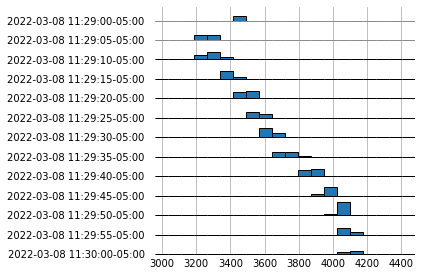

PARAM $1 Actual


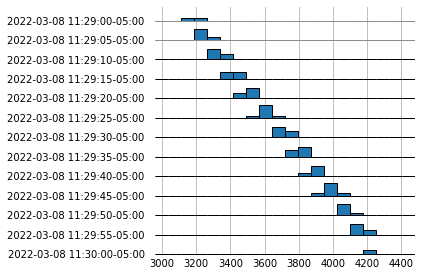

100%|██████████| 29/29 [00:07<00:00,  3.66it/s]


PARAM $2 Predicted


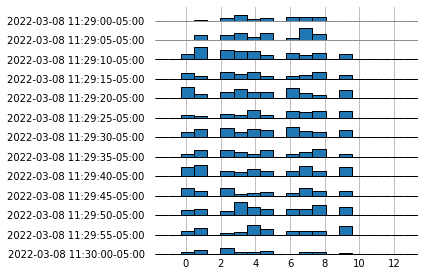

PARAM $2 Actual


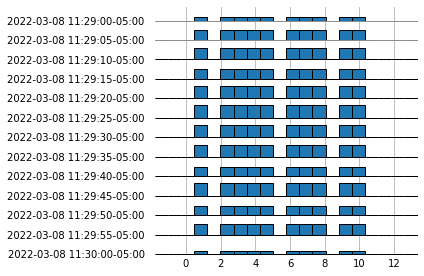

100%|██████████| 29/29 [00:04<00:00,  6.85it/s]


PARAM $3 Predicted


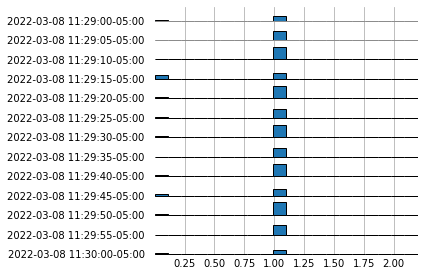

PARAM $3 Actual


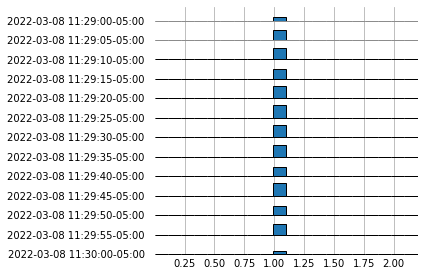

In [42]:
query_template_to_index = {qt: i for i, qt in enumerate(list(query_to_df_normalized_map.keys()))}
get_all_parameters_for("DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3")

************************
DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3


100%|██████████| 29/29 [00:08<00:00,  3.53it/s]


PARAM $1 Predicted


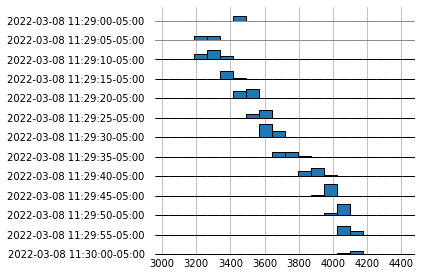

PARAM $1 Actual


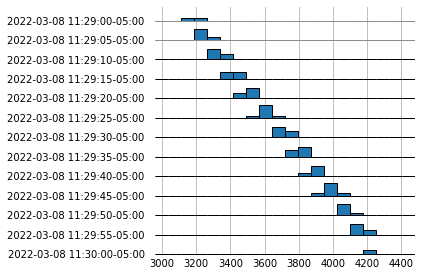

100%|██████████| 29/29 [00:09<00:00,  3.09it/s]


PARAM $2 Predicted


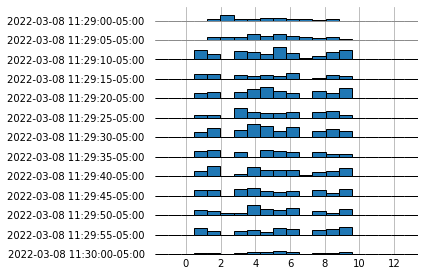

PARAM $2 Actual


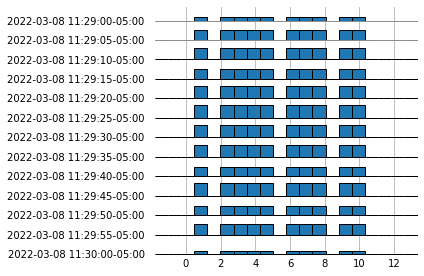

100%|██████████| 29/29 [00:05<00:00,  5.23it/s]


PARAM $3 Predicted


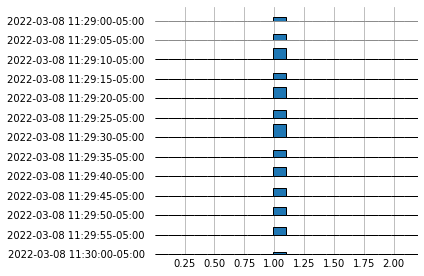

PARAM $3 Actual


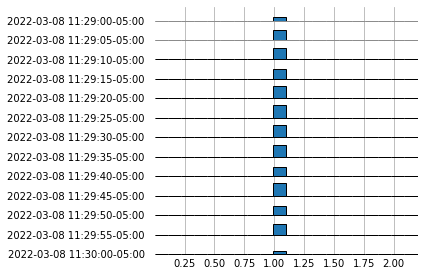




************************
SELECT COUNT(DISTINCT (S_I_ID)) AS STOCK_COUNT FROM order_line, stock WHERE OL_W_ID = $1 AND OL_D_ID = $2 AND OL_O_ID < $3 AND OL_O_ID >= $4 AND S_W_ID = $5 AND S_I_ID = OL_I_ID AND S_QUANTITY < $6


100%|██████████| 29/29 [00:00<00:00, 55.42it/s]


PARAM $1 Predicted


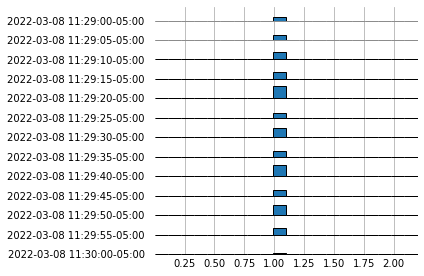

PARAM $1 Actual


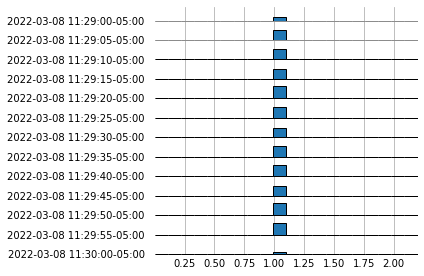

100%|██████████| 29/29 [00:00<00:00, 34.95it/s]


PARAM $2 Predicted


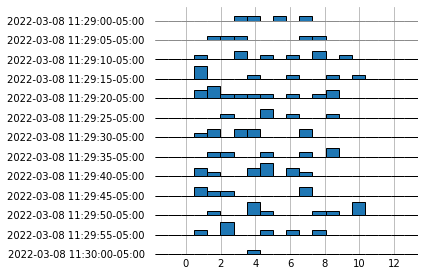

PARAM $2 Actual


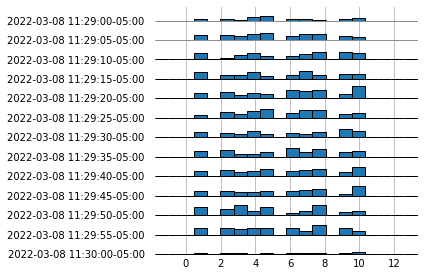

100%|██████████| 29/29 [00:00<00:00, 36.54it/s]


PARAM $3 Predicted


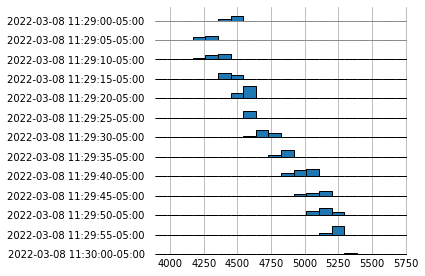

PARAM $3 Actual


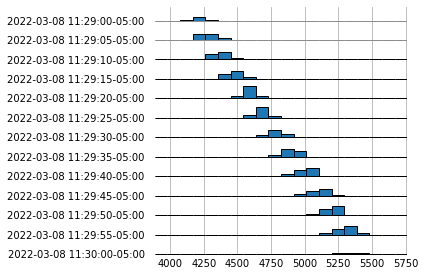

100%|██████████| 29/29 [00:00<00:00, 31.60it/s]


PARAM $4 Predicted


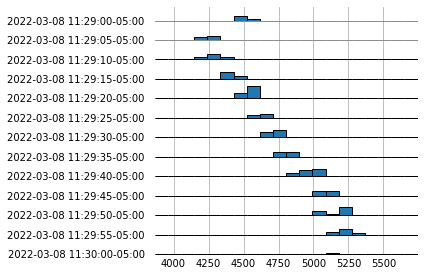

PARAM $4 Actual


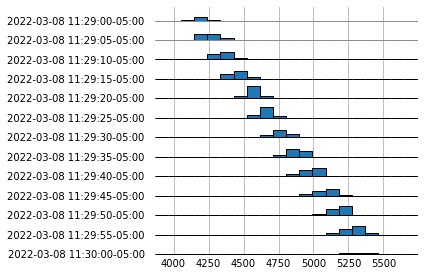

100%|██████████| 29/29 [00:00<00:00, 59.96it/s]


PARAM $5 Predicted


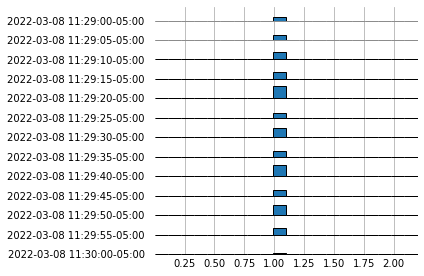

PARAM $5 Actual


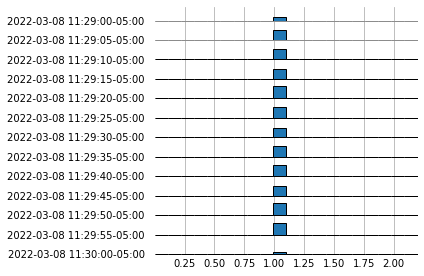

100%|██████████| 29/29 [00:00<00:00, 33.95it/s]


PARAM $6 Predicted


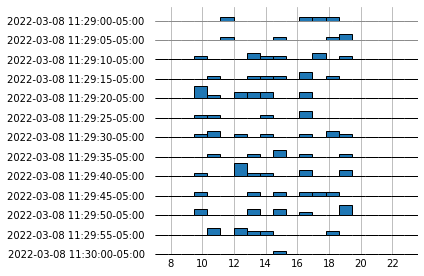

PARAM $6 Actual


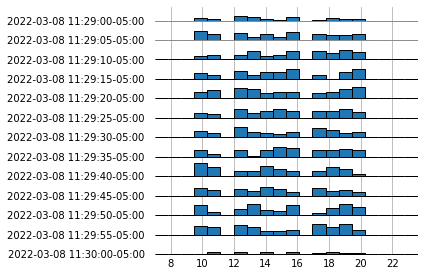




************************
SELECT D_NEXT_O_ID FROM district WHERE D_W_ID = $1 AND D_ID = $2


100%|██████████| 29/29 [00:00<00:00, 60.89it/s]


PARAM $1 Predicted


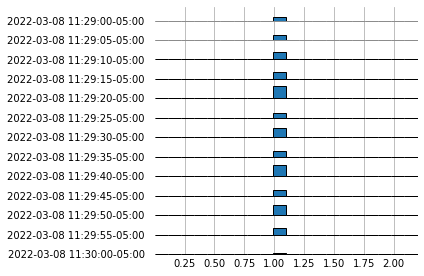

PARAM $1 Actual


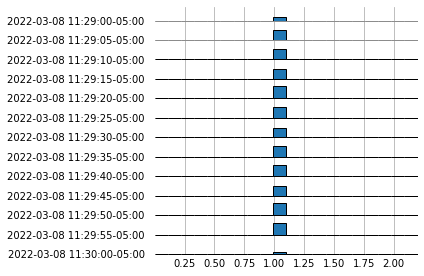

100%|██████████| 29/29 [00:00<00:00, 35.06it/s]


PARAM $2 Predicted


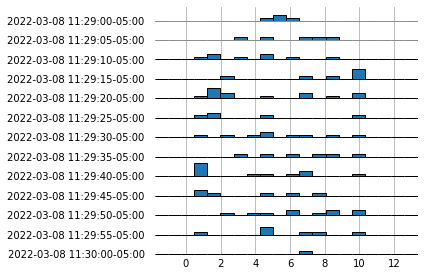

PARAM $2 Actual


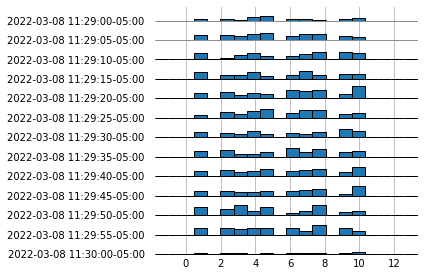




************************
SELECT OL_I_ID, OL_SUPPLY_W_ID, OL_QUANTITY, OL_AMOUNT, OL_DELIVERY_D FROM order_line WHERE OL_O_ID = $1 AND OL_D_ID = $2 AND OL_W_ID = $3


100%|██████████| 29/29 [00:00<00:00, 31.39it/s]


PARAM $1 Predicted


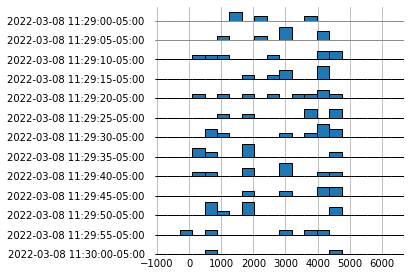

PARAM $1 Actual


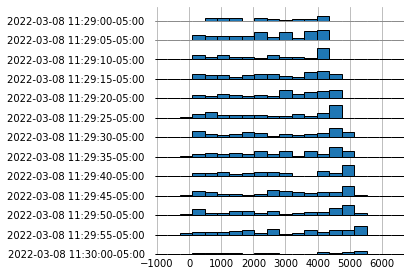

100%|██████████| 29/29 [00:00<00:00, 32.72it/s]


PARAM $2 Predicted


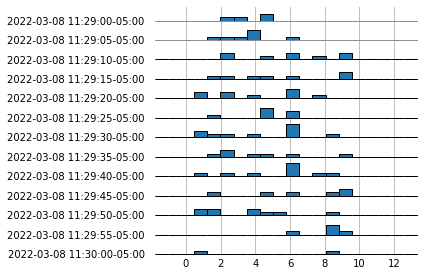

PARAM $2 Actual


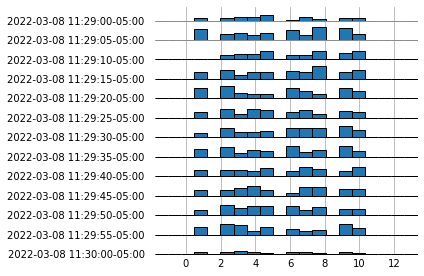

100%|██████████| 29/29 [00:00<00:00, 66.53it/s]


PARAM $3 Predicted


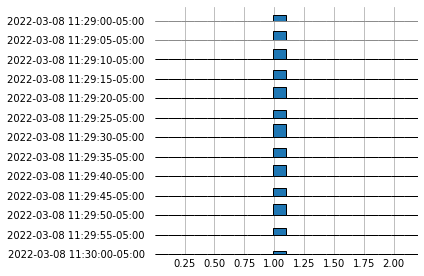

PARAM $3 Actual


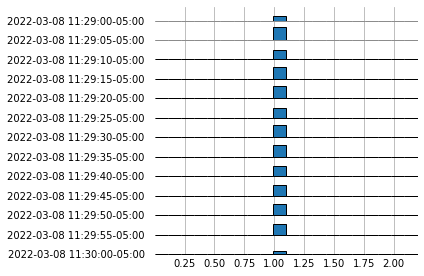




************************
SELECT W_STREET_1, W_STREET_2, W_CITY, W_STATE, W_ZIP, W_NAME FROM warehouse WHERE W_ID = $1


100%|██████████| 29/29 [00:05<00:00,  5.29it/s]


PARAM $1 Predicted


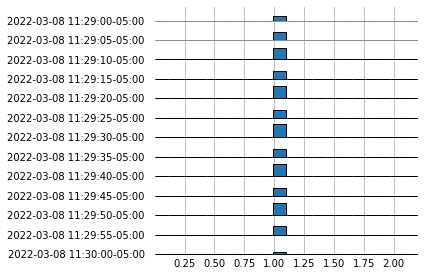

PARAM $1 Actual


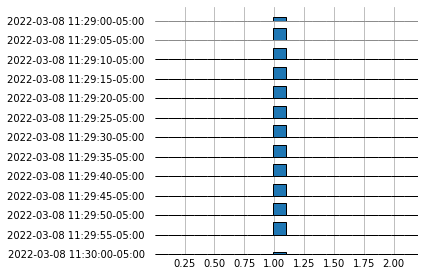




************************
UPDATE district SET D_NEXT_O_ID = D_NEXT_O_ID + $1 WHERE D_W_ID = $2 AND D_ID = $3


100%|██████████| 29/29 [00:06<00:00,  4.67it/s]


PARAM $1 Predicted


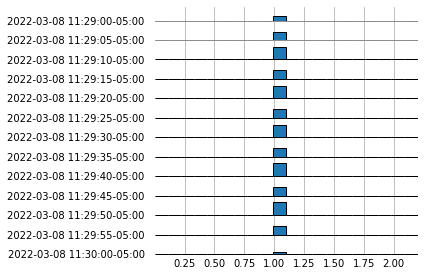

PARAM $1 Actual


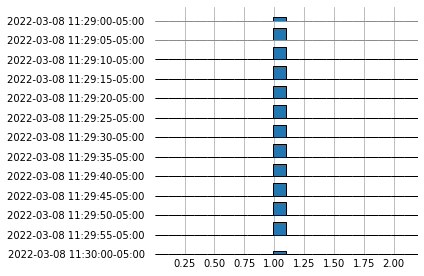

100%|██████████| 29/29 [00:05<00:00,  5.38it/s]


PARAM $2 Predicted


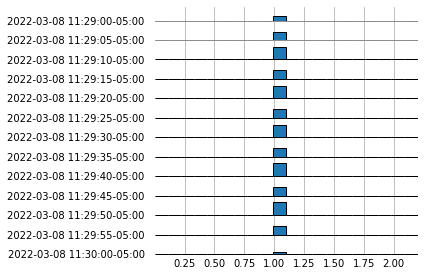

PARAM $2 Actual


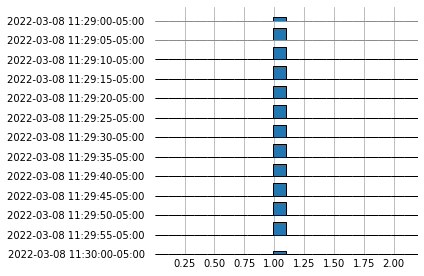

100%|██████████| 29/29 [00:10<00:00,  2.81it/s]


PARAM $3 Predicted


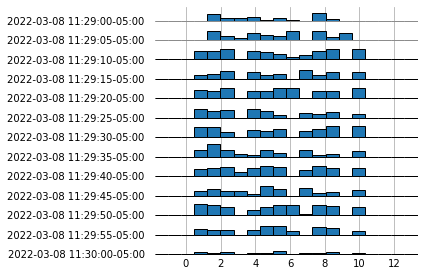

PARAM $3 Actual


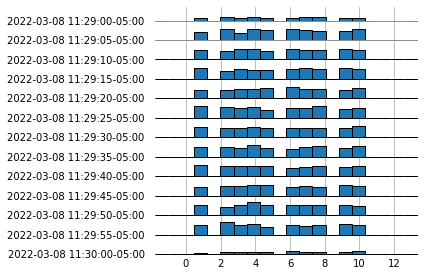




************************
UPDATE warehouse SET W_YTD = W_YTD + $1 WHERE W_ID = $2


100%|██████████| 29/29 [00:10<00:00,  2.82it/s]


PARAM $1 Predicted


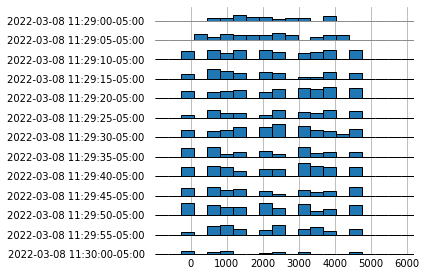

PARAM $1 Actual


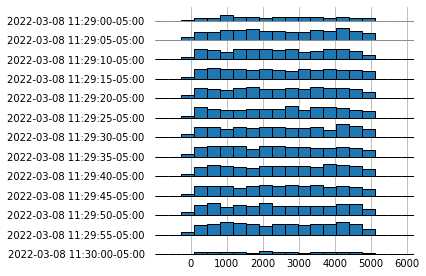

100%|██████████| 29/29 [00:05<00:00,  5.59it/s]


PARAM $2 Predicted


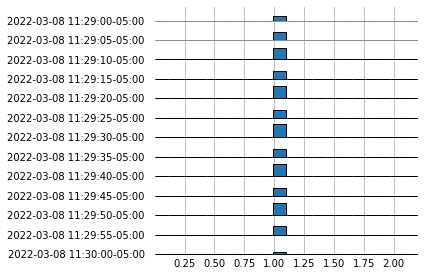

PARAM $2 Actual


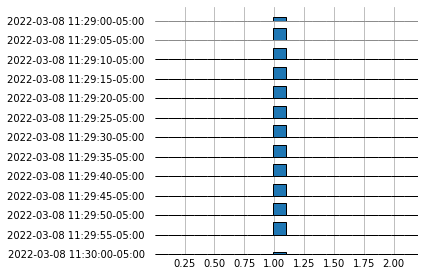

In [74]:
for i, qt in enumerate(query_template_to_index.keys()):
  if i%5 == 0:
    print(f"************************************************************************\n{qt}")
    get_all_parameters_for(qt)
    print("************************************************************************")